In [1]:
###################   Background Removal with Robust PCA   #####################
#  by - Computational_Linear_Algebra_By_Rechel_Thomas_3

import moviepy.editor as mpe
from glob import glob

In [16]:
import sys, os
import numpy as np
import scipy
#import scipy.misc
from PIL import Image

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
TOL = 1.0e-8

In [5]:
video = mpe.VideoFileClip("contents/Video_003.avi")

In [6]:
video.subclip(0,50).ipython_display(width=300)

t:   1%|▍                                                                    | 2/350 [00:00<00:25, 13.59it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [7]:
video.duration

113.57

In [58]:
# Helper Method
def create_data_matrix_from_video(video,dim_h,dim_w,k=5):    
    all_arr = []
    for i in range(k * int(video.duration)):
        images = video.get_frame(i/float(k))
        colors =  rgb2gray(images).astype(int)
        arras = Image.fromarray(colors).resize(size=(dims_h, dims_w))
        np_arr =  np.array(arras)
        arr = np_arr.flatten()
        all_arr.append(arr)
    return np.vstack(all_arr).T    


#def create_data_matrix_from_video(clip, k=5, scale=50):
 #   return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
  #                    scale).flatten() for i in range(k * int(clip.duration))]).T

In [9]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [10]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [11]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

In [77]:
# Load & view data

scale = 55
dims = (int(240*(scale/100)),int(320*(scale/100)))
dims_h = (int(240*(scale/100)))
dims_w = (int(320*(scale/100)))

In [78]:
M = create_data_matrix_from_video(video,dims_h,dims_w,100)

In [79]:
print(dims, M.shape)

(132, 176) (23232, 11300)


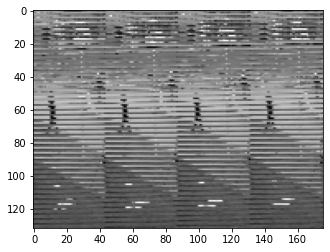

In [80]:
plt.imshow(np.reshape(M[:,140],dims),cmap="gray")

In [81]:
np.save("low_res_surveillance_matrix.npy", M)

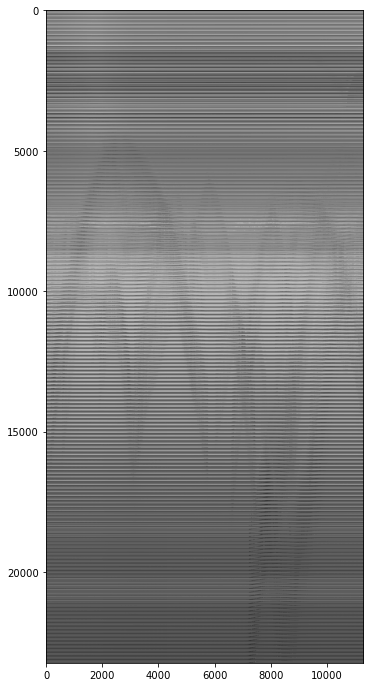

In [82]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

In [83]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

In [84]:
#####   SVD ##########
from sklearn import decomposition


In [85]:
u, s, v = decomposition.randomized_svd(M, 2)

In [86]:
u.shape, s.shape, v.shape


((23232, 2), (2,), (2, 11300))

In [87]:
low_rank = u @ np.diag(s) @ v


In [88]:
low_rank.shape


(23232, 11300)

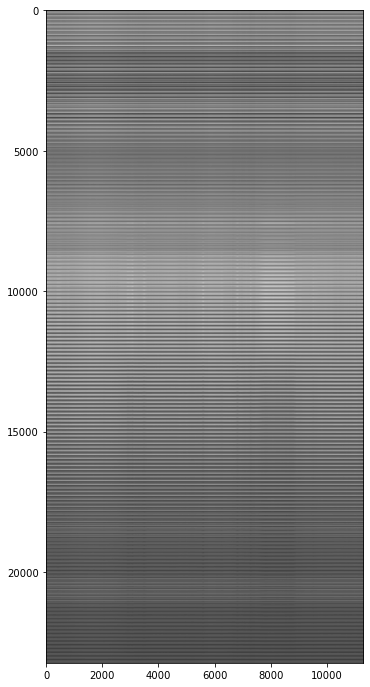

In [89]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')


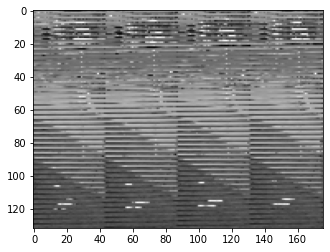

In [90]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray');


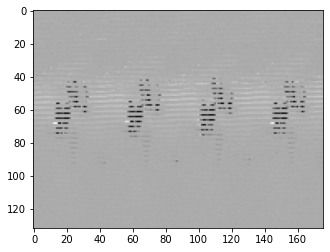

In [91]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');


In [92]:
######################################################

In [93]:
########################################################
#
#    Principal Component Analysis (PCA)
#####################################################

In [94]:
# Robust PCA factors a matrix into the sum of two matrices, M=L+S, where M is the original matrix, L is low-rank, and S is sparse
# Low-rank means that the matrix has a lot of redundant information-- in this case, it's the background
# Sparse means that the matrix has mostly zero entries

In [96]:
# Robust PCA (via Primary Component Pursuit)

from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [97]:
TOL=1e-9
MAX_ITERS=3

In [98]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [99]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [100]:
def _svd(M, rank): return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [101]:
def norm_op(M): return _svd(M, 1)[1][0]

In [102]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [103]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1/np.sqrt(m)
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [115]:
m, n = M.shape
round(m * .05)
m, n = M.shape
M = M[:12000,:5000]
m,n = M.shape
m,n

(12000, 5000)

In [116]:
L, S, examples =  pcp(M, maxiter=3, k=5)

rank sv: 1


MemoryError: Unable to allocate 458. MiB for an array with shape (12000, 5000) and data type float64

In [110]:
plots(examples, dims, rows=5)

NameError: name 'examples' is not defined

In [ ]:
f = plt_images(M, S, L, [140], dims)
np.save("high_res_L.npy", L)
np.save("high_res_S.npy", S)
f = plt_images(M, S, L, [0, 100, 1000], dims)